# **Import**

In [1]:
!pip install xlrd>=2.0.1
!pip install xlsxwriter
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
from google.colab import files
import xlsxwriter
import sys
import xlrd
from math import sqrt
from copy import deepcopy
from scipy import optimize
from scipy import stats
from random import randrange, choice
from pylab import rcParams
import seaborn as sb
import decimal as decimal
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, lpDot, LpVariable, value
from copy import deepcopy
from itertools import combinations, product

In [3]:
EPS = sys.float_info.epsilon

# **Parsing**

In [4]:
def get_html(url, params=None):
    if params:
        send = requests.get(url+params, headers=HEADERS)
    else:
        send = requests.get(url, headers=HEADERS)
    return send

## **QS+THE+ARWU+ARTU parser (426)**

Из соображений удобства данные взяты с [официального сайта ARTU](https://research.unsw.edu.au/artu/artu-results)

In [5]:
URL = 'https://research.unsw.edu.au/artu/artu-results'
HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.174 YaBrowser/22.1.5.810 Yowser/2.5 Safari/537.36}', 'accept': '*/*'}

In [6]:
def get_content_ARTU(html):
    soup = BeautifulSoup(html, 'lxml')
    ranking_table = soup.find('table', attrs={'class': 'full-ranking'})
    rows = ranking_table.find_all('tr')
    ranking = []
    del rows[0]
    for row in rows:
        columns = row.find_all('td')
        ranking.append(
            {
                'university name': row.find('a').get_text().split(' (')[0],
                'ARWU': columns[-5].get_text(),
                'QS': columns[-4].get_text(),
                'THE': columns[-3].get_text(),
                'ARTU': columns[-1].get_text()
            }
        )
    return ranking

In [7]:
def parse_ARTU():
    html = get_html(URL)
    if html.status_code == 200:
        return get_content_ARTU(html.text)
    else:
        print("ERROR")

In [8]:
four_rankings = parse_ARTU()
# display(four_rankings)

## **CWUR**

Данные взяты с [официального сайта](https://cwur.org/2021-22.php)

In [9]:
URL = 'https://cwur.org/2021-22.php'
HEADERS = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.174 YaBrowser/22.1.5.810 Yowser/2.5 Safari/537.36}', 'accept': '*/*'}

In [10]:
def get_content_CWUR(html):
    soup = BeautifulSoup(html, 'html.parser')
    ranking_table = soup.find('table', attrs={'id': 'cwurTable'})
    rows = ranking_table.find_all('tr')
    del rows[0]
    ranking = []
    score_prev = 101
    rank = 0
    for row in rows:
        score_now = float(row.find_all('td')[8].get_text())
        if abs(score_now - score_prev) > EPS:
            rank += 1
            score_prev = score_now
        ranking.append(
            {
                'university name': row.find('a').get_text(),
                'CWUR': rank
            }
        )
    return ranking

In [11]:
def parse_CWUR():
    html = get_html(URL)
    if html.status_code == 200:
        return get_content_CWUR(html.text)
    else:
        print("ERROR")

In [12]:
CWUR = parse_CWUR()
# display(CWUR)

## **RUR**

Данные были скачаны с [официального сайта](https://roundranking.com/ranking/world-university-rankings.html#world-2021) и загружены на [GitHub](https://github.com/AngelinaYudina/Universities) в формате csv (разделитель ;).

In [13]:
!wget https://raw.githubusercontent.com/AngelinaYudina/Universities/main/RUR%202021.csv

--2022-10-15 09:53:52--  https://raw.githubusercontent.com/AngelinaYudina/Universities/main/RUR%202021.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54042 (53K) [text/plain]
Saving to: ‘RUR 2021.csv.6’

RUR 2021.csv.6      100%[===================>]  52.78K  --.-KB/s    in 0.008s  

2022-10-15 09:53:52 (6.62 MB/s) - ‘RUR 2021.csv.6’ saved [54042/54042]



In [14]:
RUR_df = pd.read_csv("/content/RUR 2021.csv", delimiter=';')[['Rank', 'University']]
RUR_df.head()

,Rank,University
0,1,Harvard University
1,2,California Institute of Technology (Caltech)
2,3,Stanford University
3,4,Imperial College London
4,5,Karolinska Institute


In [15]:
RUR = []
for i in range(len(RUR_df)):
    RUR.append(
        {
            'university name': RUR_df["University"].iloc[i].split(' (')[0],
            'RUR': RUR_df["Rank"].iloc[i]
        }
    )
# RUR

# **M & T**

In [16]:
four_rankings_df = pd.DataFrame(four_rankings, index=[four_rankings[i]['university name'] for i in range(len(four_rankings))])
four_rankings_df.drop(columns=['university name'], inplace=True)
CWUR_df = pd.DataFrame(CWUR, index=[CWUR[i]['university name'] for i in range(len(CWUR))])
CWUR_df.drop(columns=['university name'], inplace=True)
RUR_df = pd.DataFrame(RUR, index=[RUR[i]['university name'] for i in range(len(RUR))])
RUR_df.drop(columns=['university name'], inplace=True)

In [17]:
df = pd.merge(four_rankings_df, CWUR_df, left_index=True, right_index=True)
df = pd.merge(df, RUR_df, left_index=True, right_index=True)
df = df.astype(np.int64)   # переводим все строки в числа
df = df.sort_values('ARWU')
df

,ARWU,QS,THE,ARTU,CWUR,RUR
Harvard University,1,5,2,1,1,1
Stanford University,2,3,4,2,3,3
University of Cambridge,3,3,5,5,4,9
Massachusetts Institute of Technology,4,1,5,3,2,6
"University of California, Berkeley",5,32,8,15,12,58
...,...,...,...,...,...,...
"Royal Holloway, University of London",813,334,362,365,155,202
University of Stirling,815,471,364,386,186,410
Heriot-Watt University,815,270,504,378,172,255
Hong Kong Baptist University,821,287,477,377,171,385


In [18]:
rankings = list(df.columns)
for ranking in rankings:
    res = []
    to_change = []
    col = deepcopy(list(df[ranking]))
    col.sort()
    curr_num = 1   # по сдвинутому ранжированию
    flag = col[0]   # по текущему ранжированию
    for i in range(len(col)):
        # идем по рейтингу проверяя повторения флагом, смещаем все к началу
        if col[i] == flag:
            res.append(curr_num)
        elif col[i] != flag:
            curr_num += 1
            flag = col[i]
            res.append(curr_num)
    for i in range(len(list(df[ranking]))):
        for j in range(len(col)):
            if col[j] == list(df[ranking])[i]:
                to_change.append(res[j])
                break
    df[ranking] = to_change
df

,ARWU,QS,THE,ARTU,CWUR,RUR
Harvard University,1,4,2,1,1,1
Stanford University,2,3,3,2,3,3
University of Cambridge,3,3,4,4,4,7
Massachusetts Institute of Technology,4,1,4,3,2,5
"University of California, Berkeley",5,25,6,12,11,45
...,...,...,...,...,...,...
"Royal Holloway, University of London",221,163,157,205,120,137
University of Stirling,222,190,159,214,134,224
Heriot-Watt University,222,141,187,212,130,164
Hong Kong Baptist University,223,149,181,211,129,217


Строим матрицу строгого мажоритарного отношения:

In [19]:
values = df.values
M = np.zeros((values.shape[0], values.shape[0]))
T = np.zeros((values.shape[0], values.shape[0]))
num = 0
for i in range(values.shape[0]):
    for j in range(values.shape[0]):
        counter = 0
        for k in range(1, values.shape[1]):   # идем по ранжированиям
            if values[i][k] < values[j][k]:
                counter += 1
            elif values[i][k] > values[j][k]:
                counter -= 1
        if np.sign(counter) == 1:
            M[i][j] = 1
        elif np.sign(counter) == 0 and i != j:
            T[i][j] = 1
            num += 1
M_df = pd.DataFrame(M)
M_df = M_df.astype(np.int64)   # переводим все в целые числа
# M_df

Строим матрицу отношения равенства голосов:

In [20]:
T_df = pd.DataFrame(T)
T_df = T_df.astype(np.int64)   # переводим все в целые числа
# T_df

# **Tournament Solutions**

In [21]:
def game_creator(M):
    return M - M.T

Верхний срез альтернативы: $D(x)=\{ y \in X ~\big|~ y \succ x \}$

Нижний срез альтернативы: $L(x)=\{ y \in X ~\big|~ x \succ y \}$

Горизонт альтернативы: $H(x)=\{ y \in X \setminus \{x\} ~\big|~ x \sim y \}$

In [22]:
def DLH_with_ind(G, list_ind=False):
    D = []
    L = []
    H = []
    res = {'D': D, 'L': L, 'H': H}
    ind_dict = dict()
    counter = 0
    if not list_ind:
        for i in range(len(G)):
            D_i = set(j for j in range(len(G)) if G[i][j] == -1)
            D.append(D_i)
            L_i = set(j for j in range(len(G)) if G[i][j] == 1)
            L.append(L_i)
            H_i = set(j for j in range(len(G)) if G[i][j] == 0 and i != j)
            H.append(H_i)
        return res
    for ind in list_ind:
        ind_dict[ind] = counter
        counter += 1
    for i in list_ind:
        D_i = set(j for j in list_ind if G[ind_dict[i]][ind_dict[j]] == -1)
        D.append(D_i)
        L_i = set(j for j in list_ind if G[ind_dict[i]][ind_dict[j]] == 1)
        L.append(L_i)
        H_i = set(j for j in list_ind if G[ind_dict[i]][ind_dict[j]] == 0 and ind_dict[i] != ind_dict[j])
        H.append(H_i)
    return res

Aleskerov F. Matrix-vector representation of various solution concepts / F. Aleskerov, A. Subochev // [Электронный ресурс]: NRU Higher School of Economics. Series WP7 "Математические методы анализа решений в экономике, бизнесе и политике" – 2009 – No. WP7/2009/03 – Режим доступа: https://publications.hse.ru/mirror/pubs/share/folder/t0hpioprz1/direct/69716978.pdf, свободный. (дата обращения: 12.10.21). 

In [23]:
def UC(G):
    all_alt = set(i for i in range(len(G)))
    DLH_dict = DLH_with_ind(G)
    covered_IIa = set()
    covered_IIIa = set()
    covered_IIb = set()
    covered_IIIb = set()
    covered_IVa = set()
    covered_Va = set()
    for i in range(len(G)):
        for j in range(len(G)):
            if DLH_dict['L'][j] < DLH_dict['L'][i]:
                covered_IIb.add(j)
                if G[i][j] == 1:
                    covered_IIa.add(j)
            if DLH_dict['D'][i] < DLH_dict['D'][j]:
                covered_IIIb.add(j)
                if G[i][j] == 1:
                    covered_IIIa.add(j)
            if (G[i][j] == 1 and (((DLH_dict['L'][j] < DLH_dict['L'][i]) and 
                                  (DLH_dict['D'][i] <= DLH_dict['D'][j])) or 
                                  ((DLH_dict['L'][j] <= DLH_dict['L'][i]) and 
                                  (DLH_dict['D'][i] < DLH_dict['D'][j])))):
                covered_IVa.add(j)
            if DLH_dict['H'][j].union(DLH_dict['L'][j]) < DLH_dict['L'][i]:
                covered_Va.add(j)
    UC_IIa = all_alt - covered_IIa
    UC_IIb = all_alt - covered_IIb
    UC_IIIa = all_alt - covered_IIIa
    UC_IIIb = all_alt - covered_IIIb
    UC_IVa = all_alt - covered_IVa
    UC_Va = all_alt - covered_Va
    return {'UC_IIa': UC_IIa, 'UC_IIIa': UC_IIIa, 'UC_IVa': UC_IVa, 'UC_Va': UC_Va, 'UC_IIb': UC_IIb, 'UC_IIIb': UC_IIIb}

## **Объединение минимальных внешне устойчивых множеств (ES)**

$$x \in ES \Leftrightarrow \exists y \in UC_F: xPy \lor x\in UC_F$$

Subochev, A. Dominant, Weakly Stable, Uncovered Sets: Properties and Extensions / A. Subochev // [Электронный ресурс]: Working paper WP7/2008/03 – Moscow: SU - Higher School of Economics – 2008 – Режим доступа: https://publications.hse.ru/mirror/pubs/share/folder/79lnufol4w/direct/69717176.pdf, свободный. (дата обращения: 13.10.21).

In [24]:
def comp_UC_IIIa(G, list_ind):
    all_alt = set(list_ind)
    DLH_dict = DLH_with_ind(G, list_ind)
    ind_dict = dict()
    counter = 0
    for ind in list_ind:
        ind_dict[ind] = counter
        counter += 1
    covered_IIIa = set()
    for i in list_ind:
        for j in list_ind:
            if (DLH_dict['D'][ind_dict[i]] < DLH_dict['D'][ind_dict[j]]) and G[ind_dict[i]][ind_dict[j]] == 1:
                covered_IIIa.add(j)
    UC_IIIa = all_alt - covered_IIIa
    return UC_IIIa

In [25]:
def comp_ES(G, list_ind):
    G = G.values
    res = comp_UC_IIIa(G, list_ind)
    y_list = list(res)
    DLH_dict = DLH_with_ind(G, list_ind)
    ind_dict = dict()
    counter = 0
    for ind in list_ind:
        ind_dict[ind] = counter
        counter += 1
    for y in y_list:
        D_y = DLH_dict['D'][ind_dict[y]]
        for el in D_y:
            res.add(el)
    return res

## **Copeland rule (2 v.)**

In [26]:
def CO_II(G):
    L_dict = DLH_with_ind(G)['L']
    return list(map(len, L_dict))

In [27]:
def comp_CO_II(G, list_ind):
    G = G.values
    res = CO_II(G)
    ranking_CO_II = [0]*len(G)
    place = 1
    while sum(res) != (-1) * len(res):
        temp_res = (np.where(res == np.max(res)))[0]
        for el in temp_res:
            ranking_CO_II[el] = place
            res[el] = -1
        place += 1
    return ranking_CO_II

## **Copeland rule (3 v.)**

In [28]:
def CO_III(G):
    D_dict = DLH_with_ind(G)['D']
    return [len(G) - len(D) for D in D_dict]

In [29]:
def comp_CO_III(G, list_ind):
    G = G.values
    res = CO_III(G)
    ranking_CO_III = [0]*len(G)
    place = 1
    while sum(res) != (-1) * len(res):
        temp_res = (np.where(res == np.max(res)))[0]
        for el in temp_res:
            ranking_CO_III[el] = place
            res[el] = -1
        place += 1
    return ranking_CO_III

## **$UC_M$**

Aleskerov F. Matrix-vector representation of various solution concepts / F. Aleskerov, A. Subochev // [Электронный ресурс]: NRU Higher School of Economics. Series WP7 "Математические методы анализа решений в экономике, бизнесе и политике" – 2009 – No. WP7/2009/03 – Режим доступа: https://publications.hse.ru/mirror/pubs/share/folder/t0hpioprz1/direct/69716978.pdf, свободный. (дата обращения: 12.10.21). 

In [30]:
def comp_UC_IIa(G, list_ind):
  all_alt = set(list_ind)
  G = G.values
  DLH_dict = DLH_with_ind(G, list_ind)
  ind_dict = dict()
  counter = 0
  for ind in list_ind:
    ind_dict[ind] = counter
    counter += 1
  covered_IIa = set()
  for i in list_ind:
    for j in list_ind:
      if (DLH_dict['L'][ind_dict[j]] < DLH_dict['L'][ind_dict[i]]) and G[ind_dict[i]][ind_dict[j]] == 1:
        covered_IIa.add(j)
  UC_IIa = all_alt - covered_IIa
  return UC_IIa

## **Существенное множество (E)**

Brandt, F. Computing the minimal covering set / F. Brandt, F. Fischer // Mathematical Social Sciences – 2008 – vol. 56(2) – C. 254–268. 

In [31]:
def comp_E(G, list_ind=False):
    G = np.array(G)
    zeros = [0] * (len(G[0])*2 + 1)
    if not list_ind:
        list_ind = [x for x in range(len(G))]
    list_add = []
    for i in range(1, len(G[0])*2+1):
        temp = deepcopy(zeros)
        temp[i] = 1    #1 pivot
        list_add.append(temp)
    z_0 = [0 for i in range(len(G)+1)]
    zeros.pop(0)
    z = [*z_0, -1000, *zeros]
    z[0] = 1
    zeros.append(0)
    A = []
    A_1 = [0, *[1 for _ in range(len(G))], 1, *[0 for _ in range(len(G)*2)]]
    A.append(A_1)
    i = 0
    for row in np.vstack((G, G)):
        if i <= len(G)-1:
            A_i = [0, *row, *(list_add[i])]
        else:
            temp = deepcopy(row)
            temp[i-len(G)] -= 1
            A_i = [1, *temp, *(list_add[i])]
        A.append(A_i)
        i += 1 
    b = [1, *[0 for _ in range(len(A)-1)]]
    # Построение модели
    ES = LpProblem(name="ES", sense=LpMaximize)
    # Переменные задачи:
    all_ind = [0]
    for el in list_ind:
        all_ind.append(el+1)
    to_add_ind = "*"
    for i in range(len(A[0]) - len(list_ind)-1):
        all_ind.append(to_add_ind)
        to_add_ind += "*"
    p = [LpVariable(name='p'+str(i), lowBound=0) for i in all_ind]
    # Добавляем в модель ограничения:
    for k in [i for i in range(len(G[0])*2+1)]:
        ES += (lpDot(A[k], p) == b[k]), '(' + str(k + 1) + ')'
    # Добавляем целевую функцию:
    ES += lpDot(z, p)
    # Смотрим, что получилось:
    status_ES = ES.solve()
    printLP_result(ES, status_ES, G, list_ind)
    res = printLP_result(ES, status_ES, G, list_ind, True)
    return(res)

In [32]:
def printLP_result(LP_problem, LP_problem_status, G, list_ind, sol=False):
  if sol == False:
      pass
  else:
      solution = []
      counter = -1
      for v in LP_problem.variables():
          if v.varValue > EPS and "*" not in v.name and v.name != 'p0':
              solution.append(int(v.name.replace('p', ''))-1)
      return(solution)

## **$MC_{McK}$**

Brandt, F. Computing the minimal covering set / F. Brandt, F. Fischer // Mathematical Social Sciences – 2008 – vol. 56(2) – C. 254–268. 

In [33]:
def comp_MC_IVa(G, list_ind):
    G = G.values
    B = set(comp_E(G))
    G_copy = deepcopy(G)
    all_alt = set([x for x in range(len(G))])
    all_alt_list = [x for x in range(len(G))]
    while True:
        temp_res = set()
        for el in all_alt - B:
            G_0 = pd.DataFrame(G_copy)
            el_to_del = set([x for x in all_alt - B.union(set([el]))])
            G_0.drop(index=el_to_del, axis=0, inplace=True)
            G_0.drop(columns=el_to_del, inplace=True)
            G_0 = np.array(G_0)
            UC_IVa = UC(G_0)['UC_IVa']
            el_to_stay = list(B.union(set([el])))
            el_to_stay.sort()
            to_add = []
            for ind in UC_IVa:
              to_add.append(el_to_stay[ind])
            if set(to_add).intersection(set([el])) != set():
              temp_res.add(el)
        if len(temp_res) == 0:
            B_res = set()
            for el in list(B):
                B_res.add(list_ind[el])
            return B_res
        else:
            G_A = pd.DataFrame(G_copy)
            el_to_del = set([x for x in all_alt - temp_res])
            el_to_stay = list(temp_res)
            el_to_stay.sort()
            G_A.drop(index=el_to_del, axis=0, inplace=True)
            G_A.drop(columns=el_to_del, inplace=True)
            G_A = np.array(G_A)
            A_new = comp_E(G_A)
            to_add = []
            for ind in A_new:
                to_add.append(el_to_stay[ind])
            B = B.union(set(to_add))

## **$MC_D$**

Вычисляется аналогично $MC_{McK}$

In [34]:
def comp_MC_Va(G, list_ind):
    G = G.values
    B = set(comp_E(G))
    G_copy = deepcopy(G)
    all_alt = set([x for x in range(len(G))])
    all_alt_list = [x for x in range(len(G))]
    while True:
        temp_res = set()
        for el in all_alt - B:
            G_0 = pd.DataFrame(G_copy)
            el_to_del = set([x for x in all_alt - B.union(set([el]))])
            G_0.drop(index=el_to_del, axis=0, inplace=True)
            G_0.drop(columns=el_to_del, inplace=True)
            G_0 = np.array(G_0)
            UC_Va = UC(G_0)['UC_Va']
            el_to_stay = list(B.union(set([el])))
            el_to_stay.sort()
            to_add = []
            for ind in UC_Va:
              to_add.append(el_to_stay[ind])
            if set(to_add).intersection(set([el])) != set():
              temp_res.add(el)
        if len(temp_res) == 0:
            B_res = set()
            for el in list(B):
                B_res.add(list_ind[el])
            return B_res
        else:
            G_A = pd.DataFrame(G_copy)
            el_to_del = set([x for x in all_alt - temp_res])
            el_to_stay = list(temp_res)
            el_to_stay.sort()
            G_A.drop(index=el_to_del, axis=0, inplace=True)
            G_A.drop(columns=el_to_del, inplace=True)
            G_A = np.array(G_A)
            A_new = comp_E(G_A)
            to_add = []
            for ind in A_new:
                to_add.append(el_to_stay[ind])
            B = B.union(set(to_add))

# **Ranking**

In [35]:
final_result = []
N = np.shape(M_df)[0]
functions = [comp_CO_II, comp_CO_III, comp_UC_IIa, comp_ES, comp_E, comp_MC_IVa, comp_MC_Va]
sol_names = ["Copeland rule (2 v.)", "Copeland rule (3 v.)", "sorting by UC", "sorting by ES", "sorting by E", "sorting by MC_McK", "sorting by MC_D"]
for f in range(len(functions)):
    G = game_creator(M_df)
    M = deepcopy(M_df)
    T = deepcopy(T_df)
    list_ind = [x for x in range(N)]
    if f == 0 or f == 1:
        rank = functions[f](G, list_ind)
        final_result.append(rank)
    else:
        rating = []
        while np.shape(G)[0] != 0:
            ranked = []
            new_set = functions[f](G, list_ind)
            rating.append(new_set)
            for el in new_set:
                ranked.append(el)
            G.drop(index=ranked, axis=0, inplace=True)
            G.drop(columns=ranked, inplace=True)
            M.drop(index=ranked, axis=0, inplace=True)
            M.drop(columns=ranked, inplace=True)
            T.drop(index=ranked, axis=0, inplace=True)
            T.drop(columns=ranked, inplace=True)
            for el in ranked:
                list_ind.remove(el)
        rating_dict = dict()
        position = 1
        for el in rating:
            rating_dict[position] = [x + 1 for x in el]
            position += 1
        keys = rating_dict.keys()
        new_data = []
        indices = []
        for key in keys:
            for el in rating_dict[key]:
                indices.append(key)
                new_data.append(el)
        df_to_print = pd.DataFrame(new_data, index=indices, columns=['ID'])
        df_to_print['Position'] = indices
        names = df.index
        names_ek = names.tolist()
        names = np.asarray(names_ek)
        names_col = []
        for ind in new_data:
            names_col.append(names[ind-1])
        df_to_print[' '] = names_col
        df_to_print.drop(columns=['ID'], inplace=True)
        names_org =  df.index
        names_ek = names_org.tolist()
        names_org = np.asarray(names_ek)
        m = np.shape(names_org)[0]
        names_org = names_org.tolist()[1:m]
        df_to_print["NTP"] = names_org[ind-1]
        rank = []
        num = [x+1 for x in range(len(names))]
        for el in num:
            for key in keys:
                for row in rating_dict[key]:
                    if el in [row]:
                        rank.append(key)
        df_to_print[sol_names[f]] = rank
        final_result.append(rank)

In [36]:
for i in range(len(final_result)):
    df[sol_names[i]] = final_result[i]
df

,ARWU,QS,THE,ARTU,CWUR,RUR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D
Harvard University,1,4,2,1,1,1,1,1,1,1,1,1,1
Stanford University,2,3,3,2,3,3,2,2,2,2,2,2,2
University of Cambridge,3,3,4,4,4,7,5,5,5,5,5,5,5
Massachusetts Institute of Technology,4,1,4,3,2,5,3,3,3,3,3,3,3
"University of California, Berkeley",5,25,6,12,11,45,13,13,13,13,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Royal Holloway, University of London",221,163,157,205,120,137,129,132,52,38,68,58,56
University of Stirling,222,190,159,214,134,224,154,156,57,43,82,72,70
Heriot-Watt University,222,141,187,212,130,164,144,146,52,39,77,65,63
Hong Kong Baptist University,223,149,181,211,129,217,147,149,54,40,78,67,65


# **Rank correlation analysis**

## **Functions**

In [37]:
def fact(n):
  tmp = 1
  while n > 1:
      tmp *= n
      n -= 1
  return tmp

In [38]:
def C(n, k):
  return fact(n) / (fact(k) * fact(n - k))

In [39]:
def kendall(col1, col2):
    n_pl = 0
    n_min = 0
    n0 = 0
    n1 = 0
    n2 = 0
    dict1 = dict()
    dict2 = dict()
    for j in range(1, len(col1)+1):
        dict1[j] = len([x for x in col1 if x == j])
        dict2[j] = len([x for x in col2 if x == j])
    for key in dict1.keys():
        if dict1[key] > 1:
            n1 += C(dict1[key], 2)
        if dict2[key] > 1:
            n2 += C(dict2[key], 2)
    for i in range(len(col1)):
        for j in range(len(col2)):
            if i < j and ((col1[i] < col1[j] and col2[i] > col2[j]) or (col1[i] > col1[j] and col2[i] < col2[j])):
                n_min += 1
            elif i < j and ((col1[i] < col1[j] and col2[i] < col2[j]) or (col1[i] > col1[j] and col2[i] > col2[j])):
                n_pl += 1
    n = len(col1) * (len(col1) - 1) / 2
    n0 = (n0 - len(col1)) / 2 + len(col1)
    n0 = n_pl + n_min + n1 + n2 - n
    res = (n_pl - n_min) / sqrt((n - int(n1)) * (n - int(n2)))
    return (res, (n_pl + int(n0))/n)

## **Kendal τb**

In [40]:
corr = df.corr(method='kendall')
ind = corr.columns
k_corr = [[0 for _ in range(len(ind))] for _ in range(len(ind))]
for i in range(len(ind)):
    for j in range(len(ind)):
        k_corr[i][j] = kendall(df[ind[i]], df[ind[j]])[0]
        k_corr[j][i] = kendall(df[ind[i]], df[ind[j]])[0]

,ARWU,QS,THE,ARTU,CWUR,RUR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D
ARWU,1.000,0.525,0.577,0.734,0.753,0.514,0.694,0.692,0.690,0.685,0.693,0.698,0.698
QS,0.525,1.000,0.611,0.713,0.531,0.599,0.736,0.737,0.750,0.765,0.742,0.743,0.744
THE,0.577,0.611,1.000,0.800,0.575,0.601,0.810,0.810,0.806,0.796,0.812,0.811,0.810
ARTU,0.734,0.713,0.800,1.000,0.683,0.636,0.919,0.919,0.903,0.889,0.918,0.913,0.913
CWUR,0.753,0.531,0.575,0.683,1.000,0.575,0.703,0.701,0.710,0.701,0.704,0.710,0.710
RUR,0.514,0.599,0.601,0.636,0.575,1.000,0.701,0.701,0.718,0.727,0.706,0.715,0.716
Copeland rule (2 v.),0.694,0.736,0.810,0.919,0.703,0.701,1.000,0.997,0.962,0.929,0.971,0.971,0.971
Copeland rule (3 v.),0.692,0.737,0.810,0.919,0.701,0.701,0.997,1.000,0.962,0.929,0.972,0.971,0.971
sorting by UC,0.690,0.750,0.806,0.903,0.710,0.718,0.962,0.962,1.000,0.929,0.964,0.964,0.964
sorting by ES,0.685,0.765,0.796,0.889,0.701,0.727,0.929,0.929,0.929,1.000,0.930,0.937,0.937


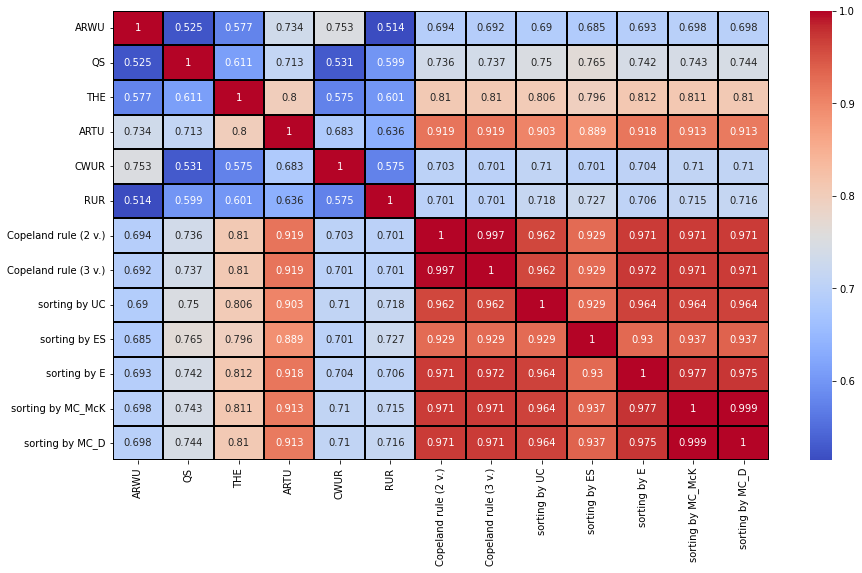

In [41]:
corr = []
for row in k_corr:
    row_corr = []
    for el in row:
        el = decimal.Decimal(round(el, 6)).quantize(decimal.Decimal('1.000'), rounding=decimal.ROUND_HALF_UP)
        row_corr.append(float(el))
    corr.append(row_corr)
corr = pd.DataFrame(corr, columns=ind, index=ind)
display(corr)
print()
col = list(df.columns)
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(corr, 
           xticklabels=col, 
           yticklabels=col,
           cmap='coolwarm',
           annot=True,
           fmt ='.3g',
           linecolor='black',
           linewidth=1)
corr_tb = corr

In [42]:
corr = df.corr(method='kendall')
ind = corr.columns
matrix = [[0 for _ in range(len(ind))] for _ in range(len(ind))]
for i in range(len(ind)):
    for j in range(len(ind)):
        val_i = 0
        val_j = 0
        if i < j:
            for k in range(7):
                if corr.iloc[k, i] > corr.iloc[k, j]:
                    val_i += 1
                elif corr.iloc[k, i] < corr.iloc[k, j]:
                    val_j += 1
            if val_i > val_j:
                matrix[i][j] = 1
            elif val_i < val_j:
                matrix[j][i] = 1
matrix_pd = pd.DataFrame(matrix, index=ind, columns=ind)

In [43]:
res = pd.DataFrame(matrix, columns=ind, index=ind)
sum_col = []
for row in matrix:
    sum_row = sum(row)
    sum_col.append(sum_row)
res["CO_2"] = sum_col
display(res)
res_tb = deepcopy(res)

,ARWU,QS,THE,ARTU,CWUR,RUR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D,CO_2
ARWU,0,0,0,0,0,0,0,0,0,0,0,0,0,0
QS,1,0,0,0,1,1,0,0,0,0,0,0,0,3
THE,1,1,0,0,1,1,0,0,0,0,0,0,0,4
ARTU,1,1,1,0,1,1,0,0,0,0,0,0,0,5
CWUR,1,0,0,0,0,1,0,0,0,0,0,0,0,2
RUR,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Copeland rule (2 v.),1,1,1,1,1,1,0,1,1,1,0,0,0,9
Copeland rule (3 v.),1,1,1,1,1,1,0,0,1,1,0,0,0,8
sorting by UC,1,1,1,1,1,1,0,0,0,1,0,0,0,7
sorting by ES,1,1,1,1,1,1,0,0,0,0,0,0,0,6


In [44]:
pos = [x+1 for x in range(len(ind))]
res.sort_values(by="CO_2", ascending=False, inplace=True)
ind_ranked = res.index
final_ranking = pd.DataFrame(ind_ranked, index=pos)
rank = []
counter = 1
value_prev = res['CO_2'].values.max()
for value in res['CO_2']:
    if value < value_prev:
        counter += 1
    rank.append(counter)
    value_prev = value
final_ranking['Rank'] = rank
display(final_ranking)
final_tb = final_ranking

,0,Rank
1,sorting by MC_D,1
2,sorting by MC_McK,2
3,sorting by E,3
4,Copeland rule (2 v.),4
5,Copeland rule (3 v.),5
6,sorting by UC,6
7,sorting by ES,7
8,ARTU,8
9,THE,9
10,QS,10


## **r**

In [45]:
r_corr = [[0 for _ in range(len(ind))] for _ in range(len(ind))]
for i in range(len(ind)):
    for j in range(len(ind)):
        r_corr[i][j] = kendall(df[ind[i]], df[ind[j]])[1]
        r_corr[j][i] = kendall(df[ind[i]], df[ind[j]])[1]

,ARWU,QS,THE,ARTU,CWUR,RUR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D
ARWU,1.000,0.761,0.788,0.866,0.873,0.757,0.844,0.843,0.826,0.801,0.837,0.834,0.834
QS,0.761,1.000,0.803,0.855,0.761,0.798,0.864,0.865,0.855,0.839,0.860,0.856,0.856
THE,0.788,0.803,1.000,0.899,0.784,0.800,0.901,0.902,0.883,0.854,0.896,0.890,0.889
ARTU,0.866,0.855,0.899,1.000,0.838,0.818,0.956,0.956,0.931,0.900,0.948,0.941,0.940
CWUR,0.873,0.761,0.784,0.838,1.000,0.784,0.846,0.845,0.834,0.807,0.840,0.838,0.838
RUR,0.757,0.798,0.800,0.818,0.784,1.000,0.848,0.848,0.840,0.821,0.844,0.843,0.843
Copeland rule (2 v.),0.844,0.864,0.901,0.956,0.846,0.848,1.000,0.996,0.960,0.918,0.974,0.969,0.969
Copeland rule (3 v.),0.843,0.865,0.902,0.956,0.845,0.848,0.996,1.000,0.960,0.919,0.975,0.969,0.969
sorting by UC,0.826,0.855,0.883,0.931,0.834,0.840,0.960,0.960,1.000,0.917,0.960,0.959,0.958
sorting by ES,0.801,0.839,0.854,0.900,0.807,0.821,0.918,0.919,0.917,1.000,0.919,0.921,0.922


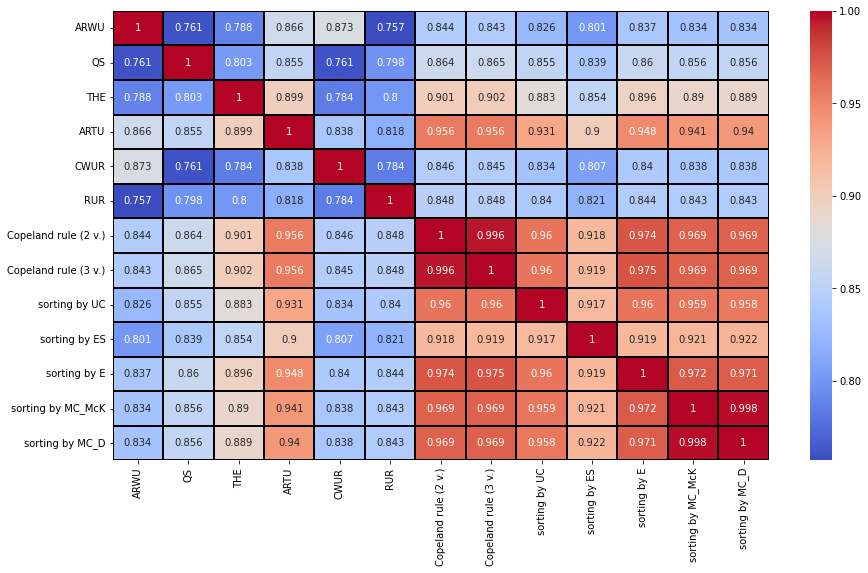

In [46]:
corr = []
for row in r_corr:
    row_corr = []
    for el in row:
        el = decimal.Decimal(round(el, 6)).quantize(decimal.Decimal('1.000'), rounding=decimal.ROUND_HALF_UP)
        row_corr.append(float(el))
    corr.append(row_corr)
corr = pd.DataFrame(corr, columns=ind, index=ind)
display(corr)
print()
col = list(df.columns)
print()
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(corr, 
           xticklabels=col, 
           yticklabels=col,
           cmap='coolwarm',
           annot=True,
           fmt ='.3g',
           linecolor='black',
           linewidth=1)
corr_r = corr

In [47]:
ind = corr.columns
matrix = [[0 for _ in range(len(ind))] for _ in range(len(ind))]
for i in range(len(ind)):
    for j in range(len(ind)):
        val_i = 0
        val_j = 0
        if i < j:
            for k in range(7):
                if corr.iloc[k, i] > corr.iloc[k, j]:
                    val_i += 1
                elif corr.iloc[k, i] < corr.iloc[k, j]:
                    val_j += 1
            if val_i > val_j:
                matrix[i][j] = 1
            elif val_i < val_j:
                matrix[j][i] = 1
matrix_pd = pd.DataFrame(matrix, index=ind, columns=ind)

In [48]:
res = pd.DataFrame(matrix, columns=ind, index=ind)
sum_col = []
for row in matrix:
    sum_row = sum(row)
    sum_col.append(sum_row)
res["CO_2"] = sum_col
display(res)
res_r = deepcopy(res)

,ARWU,QS,THE,ARTU,CWUR,RUR,Copeland rule (2 v.),Copeland rule (3 v.),sorting by UC,sorting by ES,sorting by E,sorting by MC_McK,sorting by MC_D,CO_2
ARWU,0,0,0,0,0,0,0,0,0,0,0,0,0,0
QS,1,0,0,0,1,1,0,0,0,0,0,0,0,3
THE,1,1,0,0,1,1,0,0,0,0,0,0,0,4
ARTU,1,1,1,0,1,1,0,0,1,1,0,0,0,7
CWUR,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RUR,1,0,0,0,1,0,0,0,0,0,0,0,0,2
Copeland rule (2 v.),1,1,1,1,1,1,0,1,1,1,1,1,1,12
Copeland rule (3 v.),1,1,1,1,1,1,0,0,1,1,1,1,1,11
sorting by UC,1,1,1,0,1,1,0,0,0,1,0,0,0,6
sorting by ES,1,1,1,0,1,1,0,0,0,0,0,0,0,5


In [49]:
pos = [x+1 for x in range(len(ind))]
res.sort_values(by="CO_2", ascending=False, inplace=True)
ind_ranked = res.index
final_ranking = pd.DataFrame(ind_ranked, index=pos)
rank = []
counter = 1
value_prev = res['CO_2'].values.max()
for value in res['CO_2']:
    if value < value_prev:
        counter += 1
    rank.append(counter)
    value_prev = value
final_ranking['Rank'] = rank
display(final_ranking)
final_r = final_ranking

,0,Rank
1,Copeland rule (2 v.),1
2,Copeland rule (3 v.),2
3,sorting by E,3
4,sorting by MC_McK,4
5,ARTU,5
6,sorting by MC_D,5
7,sorting by UC,6
8,sorting by ES,7
9,THE,8
10,QS,9
